In [12]:
import netCDF4 as nc
import scipy.io as sio
import os,sys,fnmatch,time
from scipy import interpolate
import numpy as np
import numpy.ma as ma
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import cmocean as cmo

from salishsea_tools.nc_tools import scDataset
from salishsea_tools import geo_tools

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot

sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

(cmapmc, norm) = functions_plot.Colormap()
from matplotlib.colors import ListedColormap
cmapmc_r = ListedColormap(cmapmc.colors[::-1])
from matplotlib.colors import LinearSegmentedColormap
colour_list = ["#c8274c","#f25546","#F06543","#e96e33",
               "#f0b038","#FFE74C","#69b944","#72b286",
               "#69b0bc","#619ee4","#4b5bbb"][::-1]
cmapIAM = LinearSegmentedColormap.from_list('mycmap', colour_list, N=500, gamma=1)

## Functions for observations

In [13]:
data = sio.loadmat('./MackenzieTransects.mat')

struct_north = data['stn']
struct_south = data['sts']

dtype_north = struct_north.dtype
dtype_south = struct_south.dtype

data_north = {n: struct_north[n][0, 0] for n in dtype_north.names}
data_south = {n: struct_south[n][0, 0] for n in dtype_south.names}

obs_lat_s = data_south['lat_adcp'][0,:]
obs_lon_s = data_south['lon_adcp'][0,:]
obs_dist_s = data_south['dist_adcp'][0,:]
obs_z_s = data_south['z_adcp'][:, 0]
obs_u_s = data_south['u'][:]
obs_v_s = data_south['v'][:]


obs_lat_n = data_north['lat_adcp'][0,:]
obs_lon_n = data_north['lon_adcp'][0,:]
obs_dist_n = data_north['dist_adcp'][0,:]
obs_z_n = data_north['z_adcp'][:, 0]
obs_u_n = data_north['u'][:]
obs_v_n = data_north['v'][:]

In [14]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def get_obs_mean(vel_n, vel_s, z, dep1, dep2):
    
    ind1 = find_nearest(z, dep1)
    ind2 = find_nearest(z, dep2)
    
    vel_mean_n = np.mean(vel_n[ind1:ind2, :], axis=0)
    vel_mean_s = np.mean(vel_s[ind1:ind2, :], axis=0)
    
    return vel_mean_n, vel_mean_s, z[ind1], z[ind2]

## Functions for model results

In [15]:
def get_deps(dirname, velocity):
    fname = "1_MCKNZ_1h_20170101_201701*"
    
    if velocity == 'U':
        name_grid = 'grid_U'
        name_depth = 'depthu'
            
    elif velocity == 'V':
        name_grid = 'grid_V'
        name_depth = 'depthv'
        
    files = general_functions.get_files(dirname, fname, name_grid)
    with scDataset(files) as ds:
        depth = ds.variables[name_depth][:]
        
    return depth

In [16]:
def get_vars(dirname, dep1, dep2, time_start, time_end, velocity):
    fname = "1_MCKNZ_1h_20170101_201701*"
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    # --------------------------------------------------------
    
    depth = get_deps(dirname, velocity)
    dep_start = find_nearest(depth, dep1)
    dep_end = find_nearest(depth, dep2)
    
    # --------------------------------------------------------
    
    if velocity == 'U':
        name_grid = 'grid_U'
        name_depth = 'depthu'
        name_vel = 'vozocrtx'
        name_mask = 'umask'
        
    elif velocity == 'V':
        name_grid = 'grid_V'
        name_depth = 'depthv'
        name_vel = 'vomecrty'
        name_mask = 'vmask'
        
    # --------------------------------------------------------
        
    files = general_functions.get_files(dirname, fname, name_grid)    
    with scDataset(files) as ds, nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        
        if dep_start != dep_end:
            dep_end_new = dep_end + 1
            depth = ds.variables[name_depth][dep_start:dep_end_new]
            vel0 = ds.variables[name_vel][time_start:time_end, dep_start:dep_end_new, y, x]
            mask0 = dsM.variables[name_mask][0, dep_start:dep_end_new, y, x]
            mask = np.tile(mask0, (vel0.shape[0], 1, 1, 1))
            vel = np.ma.array(vel0, mask=1 - mask)
        else: 
            dep_ind = int(dep_start)
            depth = ds.variables[name_depth][dep_ind]
            vel0 = ds.variables[name_vel][time_start:time_end, dep_ind, y, x]
            mask0 = dsM.variables[name_mask][0, dep_ind, y, x]
            mask = np.tile(mask0, (vel0.shape[0], 1, 1))
            vel = np.ma.array(vel0, mask=1 - mask)
        
        nav_lat = ds.variables['nav_lat'][y, x]
        nav_lon = ds.variables['nav_lon'][y, x]
            
    return vel, depth, nav_lat, nav_lon

In [17]:
def get_vars_mean(dirname, dep1, dep2, time_start, time_end, velocity):
    vel, depth, nav_lat, nav_lon = get_vars(dirname, dep1, dep2, time_start, time_end, velocity)
    if vel.shape[1] == 272:
        vel_mean = np.mean(vel, axis=0)
    else:
        vel_mean = np.mean(np.mean(vel, axis=0), axis=0)
    return vel_mean, vel, depth, nav_lat, nav_lon

## Figures

In [18]:
def plot_comparison(dirname, ttl, velocity, time_start, time_end,
                    obs_vel_n, obs_vel_s, obz_z, lon_n, lat_n, lon_s, lat_s):
    
    fig, axes = plt.subplots(4, 3, figsize=(20, 40), sharey=True, sharex=True)
    fig.tight_layout(h_pad=2.5, w_pad=0.01)
    fig.tight_layout(rect=[0, 0, 1, 0.93])
    fig.suptitle(velocity+' velocity: model results ("'+ ttl+'" case) compared to observations', fontsize=25)

    cmap = cmo.cm.balance
    cmap.set_bad('silver')
    vmin, vmax = -0.3, 0.3
    for ax, i, n in zip(axes.flatten(), np.arange(1, 24)[::2], np.arange(12)):
        dep1, dep2 = obz_z[i], obz_z[i+1]

        mod_vel_mean, mod_vel, mod_depth, mod_lat, mod_lon = get_vars_mean(dirname, dep1, dep2, time_start, time_end, velocity)

        obs_vel_mean_n, obs_vel_mean_s, obs_z_start, obs_z_end = get_obs_mean(obs_vel_n, obs_vel_s, obz_z, dep1, dep2)

        #vmin = min(np.min(mod_vel_mean), np.min(obs_vel_mean_n), np.min(obs_vel_mean_s))
        #vmax = max(np.max(mod_vel_mean), np.max(obs_vel_mean_n), np.max(obs_vel_mean_s))

        if n < 6:
            en, es = 20, 40
        else:
            en, es = 4, 4

        p = ax.pcolormesh(mod_lon, mod_lat, mod_vel_mean, cmap=cmap, vmin=vmin, vmax=vmax) 
        ax.scatter(lon_n[::en], lat_n[::en], c=obs_vel_mean_n[::en], s=100, edgecolors='k', cmap=cmap, vmin=vmin, vmax=vmax)
        ax.scatter(lon_s[::es], lat_s[::es], c=obs_vel_mean_s[::es], s=100, edgecolors='k', cmap=cmap, vmin=vmin, vmax=vmax)

        ax.set_title('mod depths ' + str(mod_depth) +
                     '\n obs depths '+ str(int(dep1)) + ' - ' + str(int(dep2)) + 
                     '\ntimes ' + str(time_start) + ' - ' + str(time_end) + ' hrs', fontsize=20)
        fig.colorbar(p, ax=ax, pad=0.025, orientation='horizontal')
        w=1/math.cos(math.radians(70.0))
        ax.set_aspect(w)
        ax.set_ylim([mod_lat.min(), mod_lat.max()])
        ax.set_xlim([mod_lon.min(), mod_lon.max()])
    
    return fig

In [19]:
start = 2
time_start, time_end = 24*start, 24*(start+1)

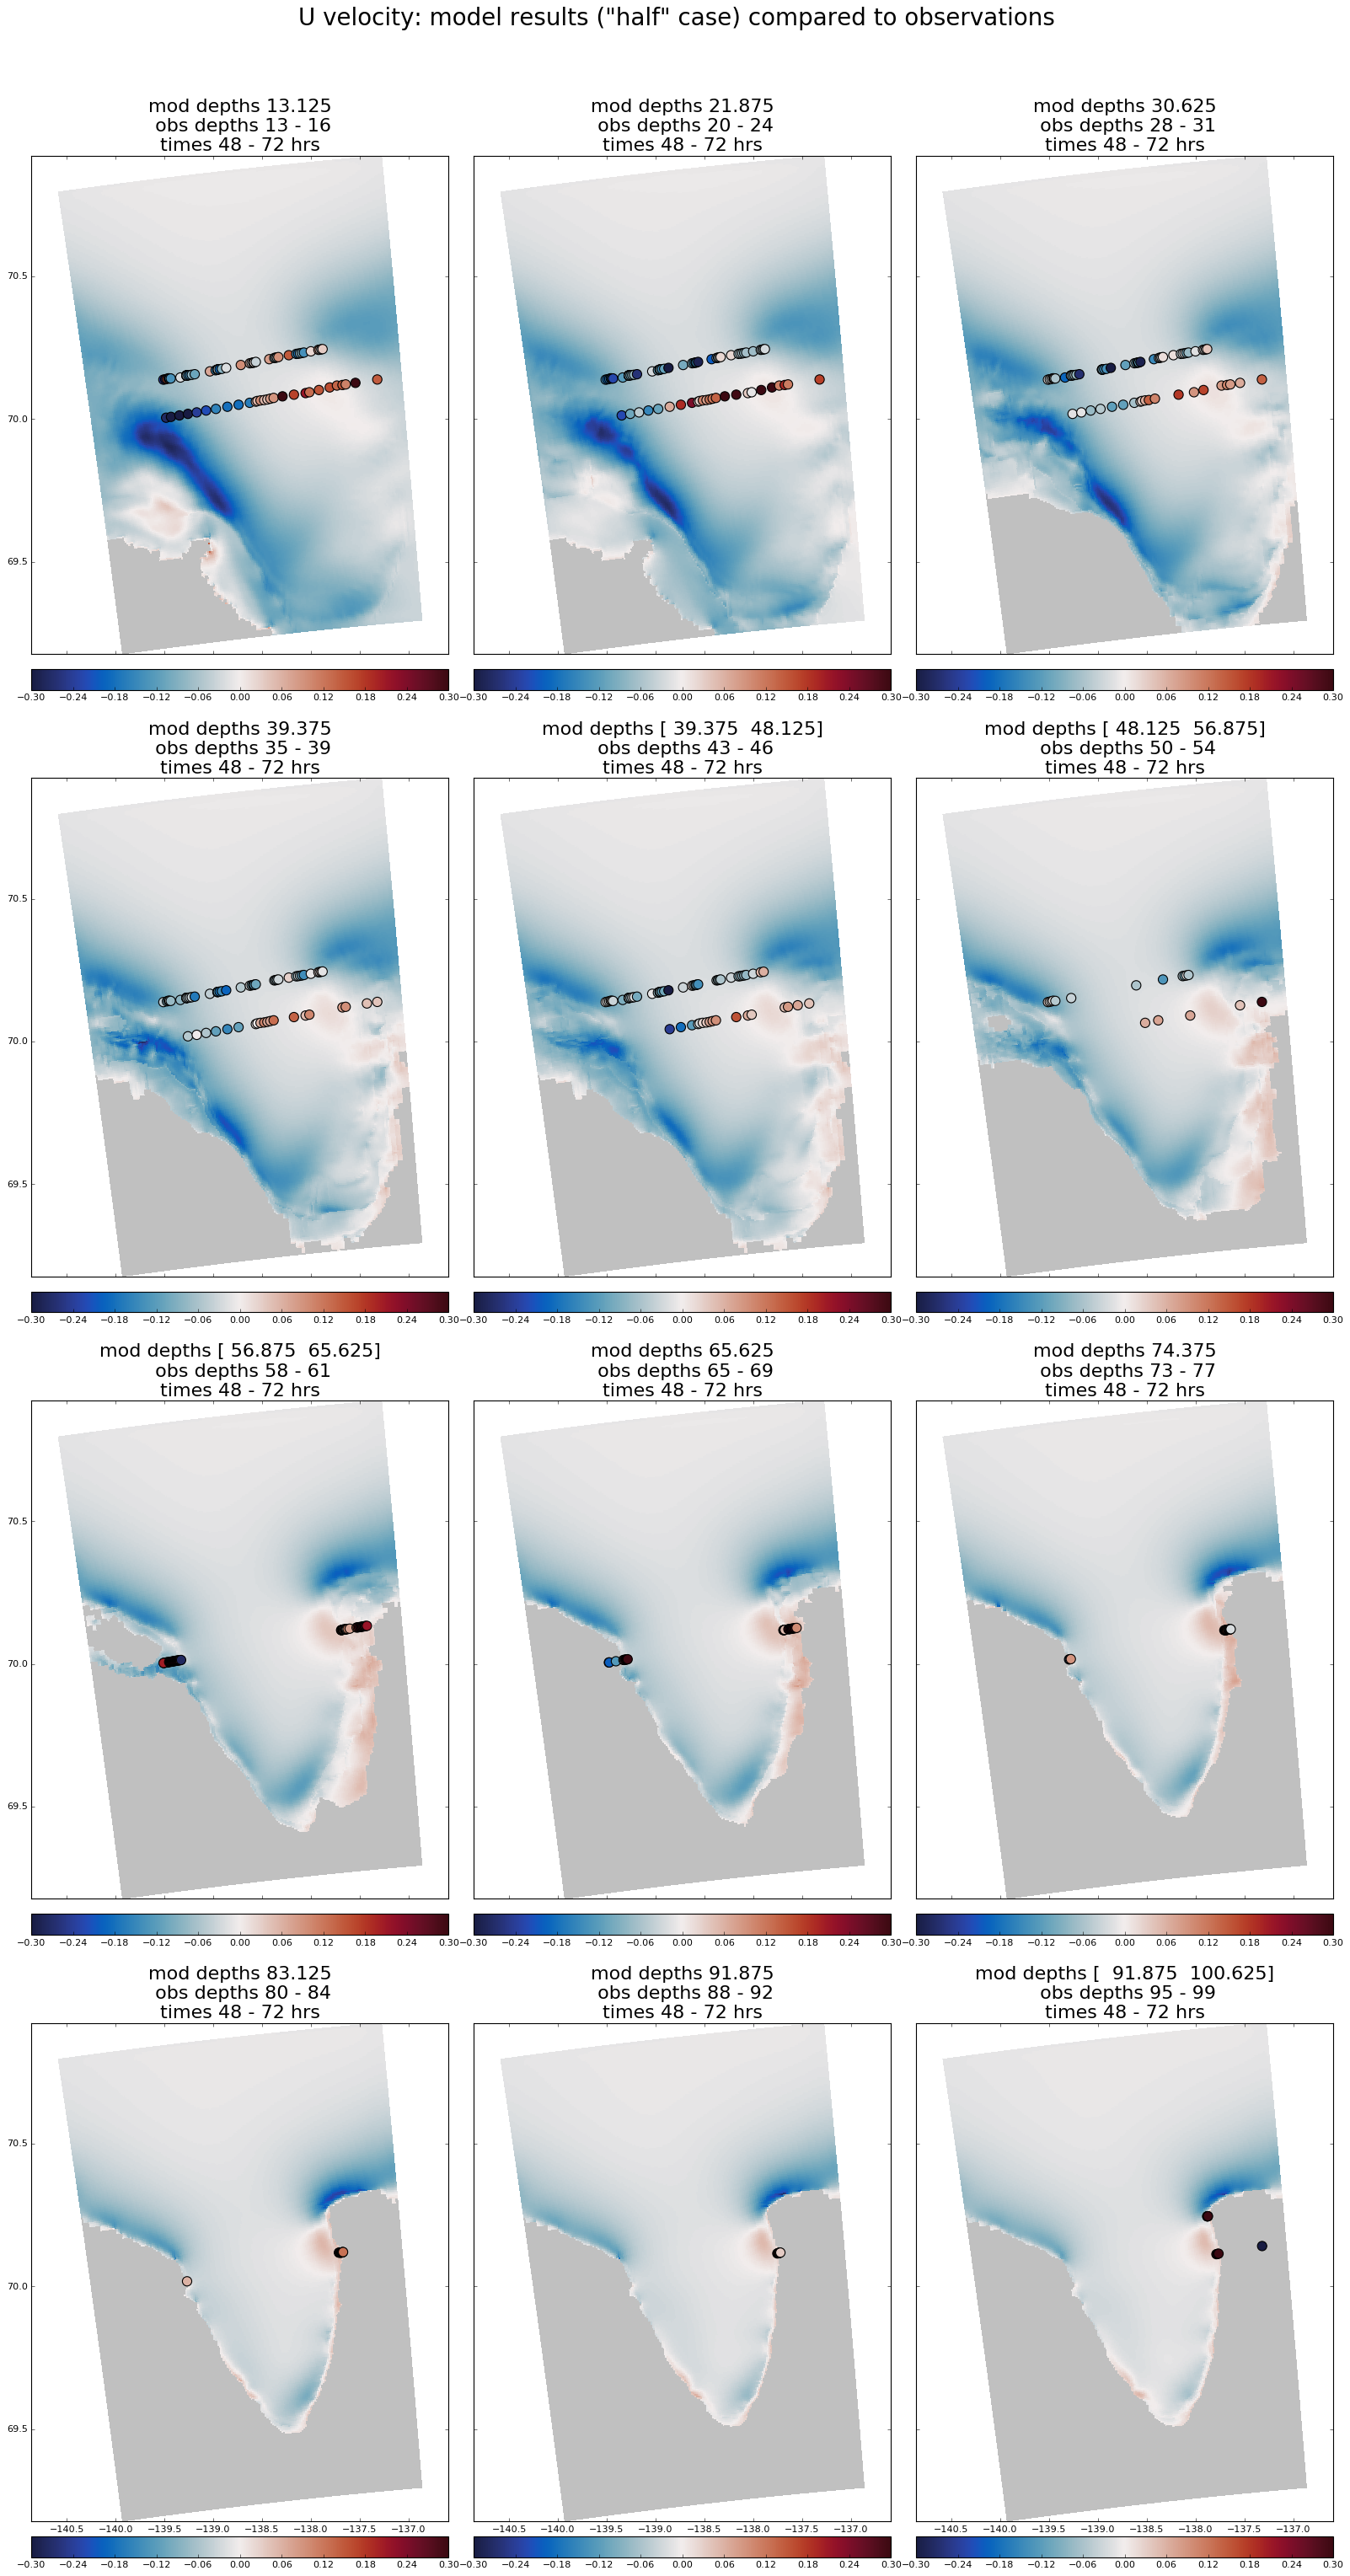

In [20]:
dirname = '/ocean/imachuca/Canyons/results_mackenzie/initial_collection/real_half/'
ttl = 'half'
velocity = 'U'

obs_vel_n = obs_u_n
obs_vel_s = obs_u_s

obz_z = obs_z_n
lon_n, lat_n = obs_lon_n, obs_lat_n
lon_s, lat_s = obs_lon_s, obs_lat_s

fig = plot_comparison(dirname, ttl, velocity, time_start, time_end, obs_vel_n, obs_vel_s, obz_z, lon_n, lat_n, lon_s, lat_s)

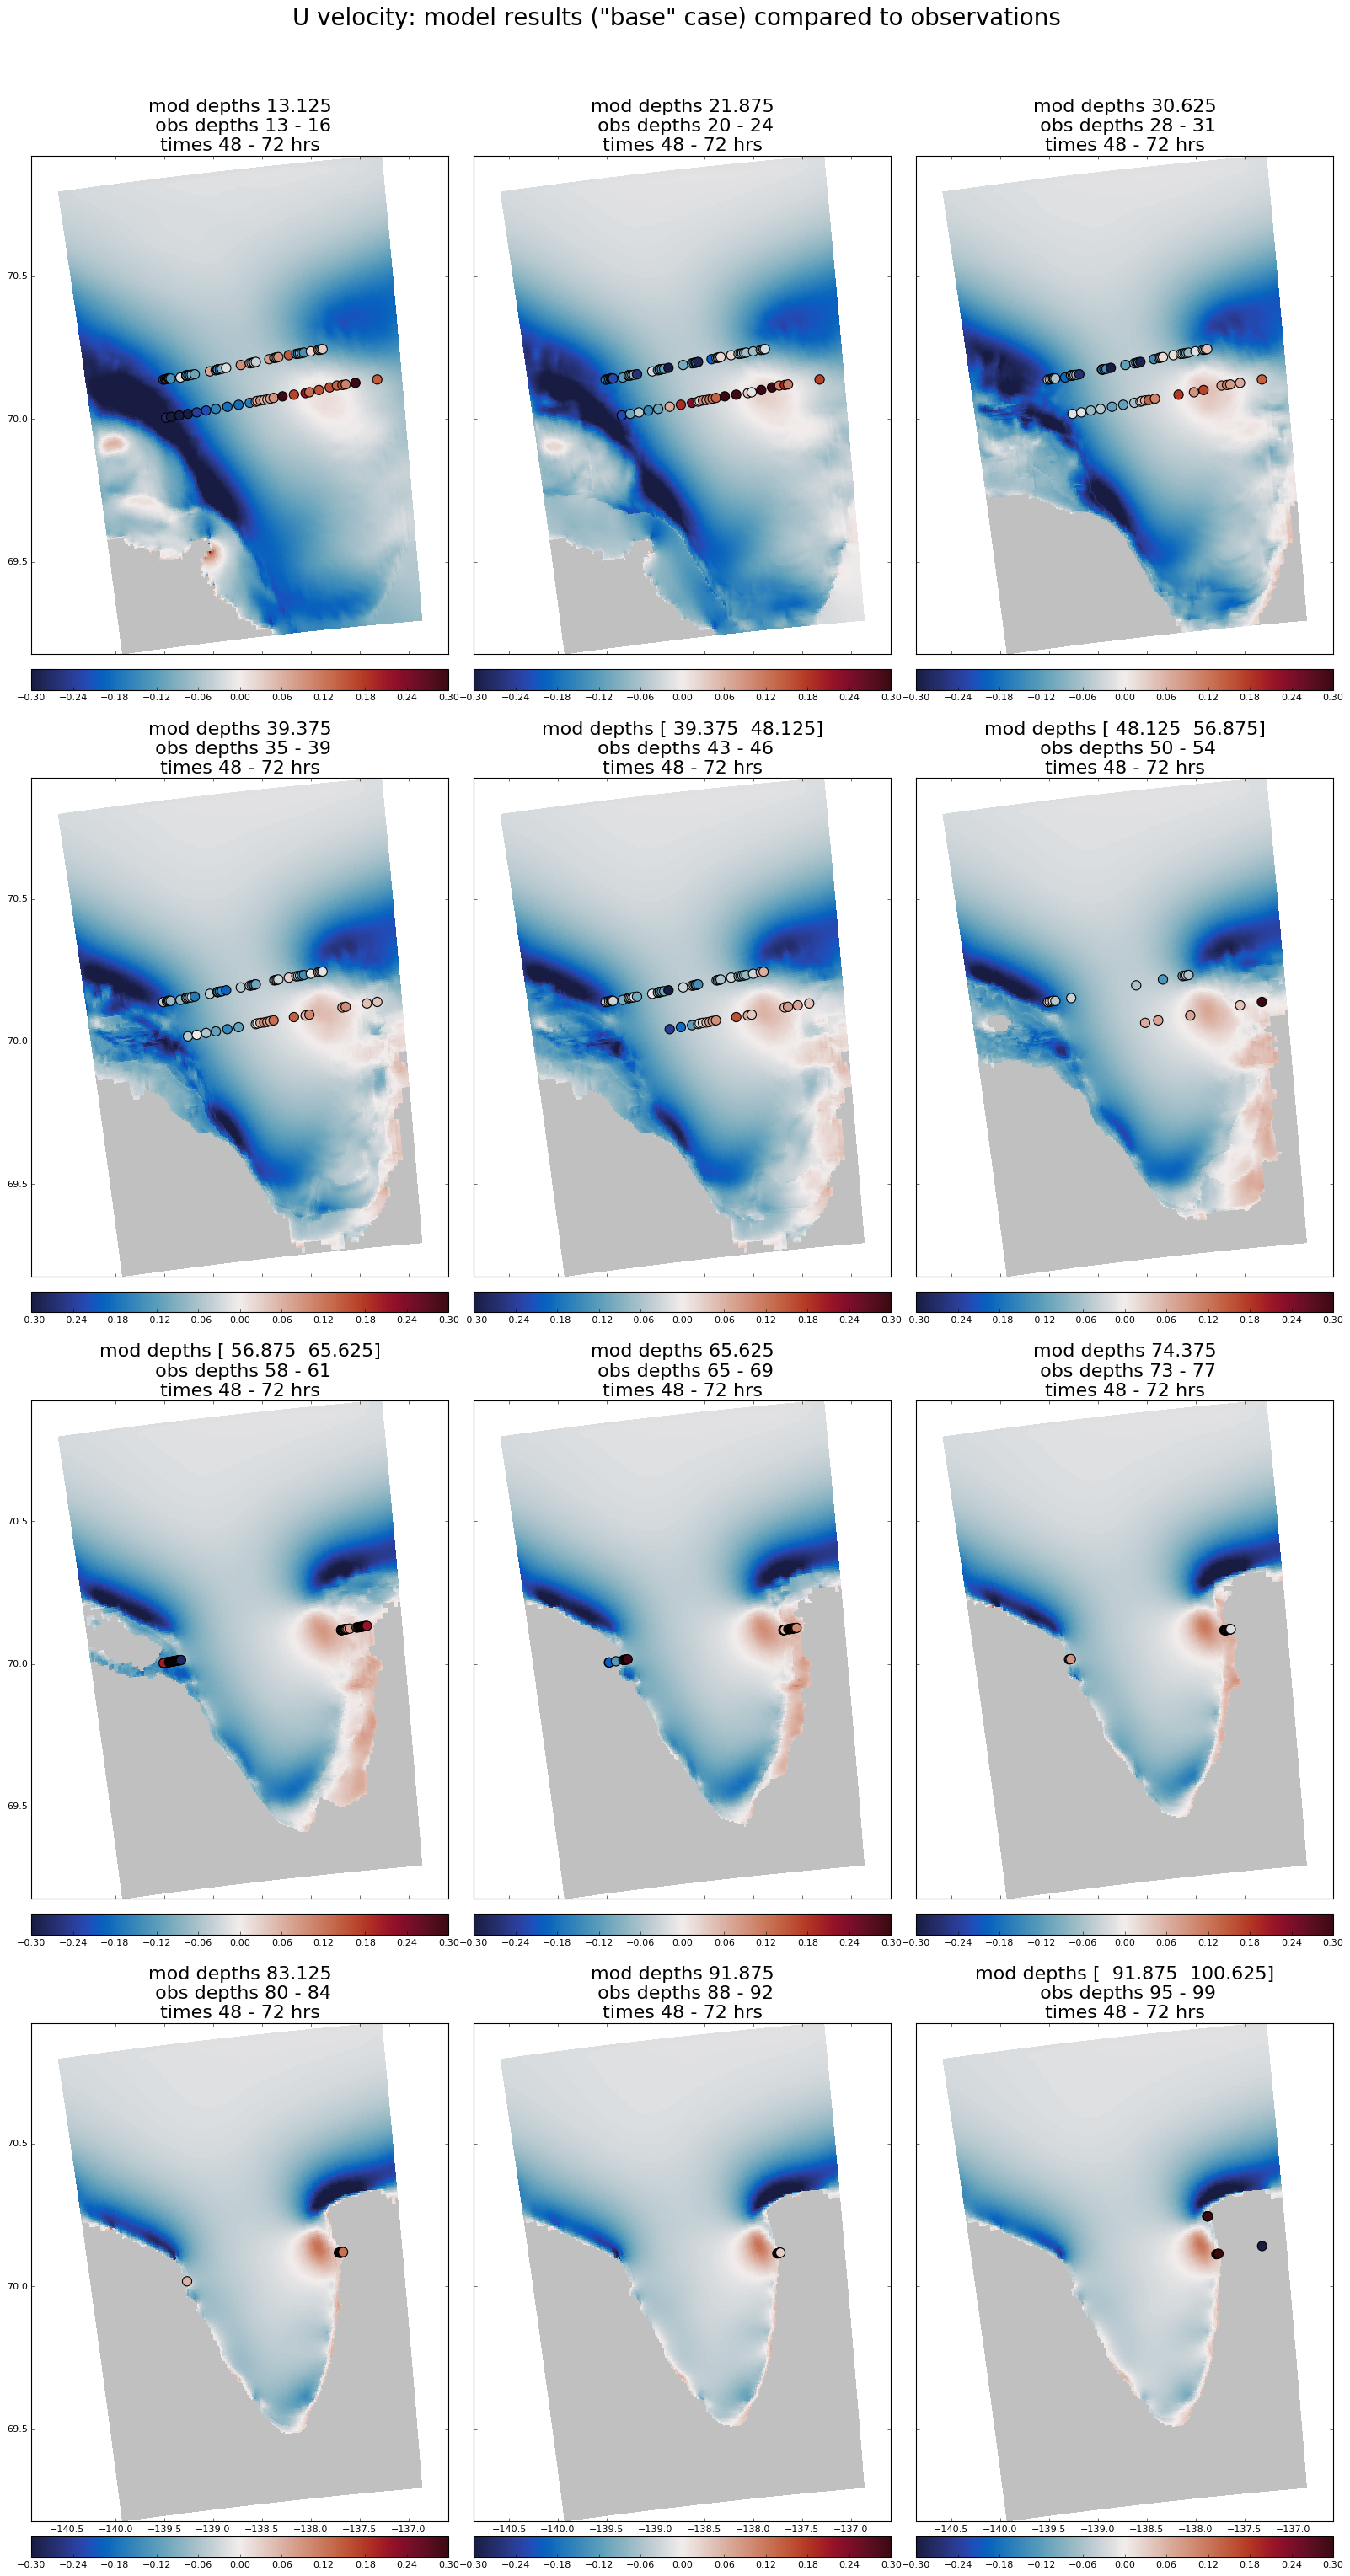

In [21]:
dirname = '/ocean/imachuca/Canyons/results_mackenzie/initial_collection/real_base/'
ttl = 'base'
velocity = 'U'

obs_vel_n = obs_u_n
obs_vel_s = obs_u_s

obz_z = obs_z_n
lon_n, lat_n = obs_lon_n, obs_lat_n
lon_s, lat_s = obs_lon_s, obs_lat_s

fig = plot_comparison(dirname, ttl, velocity, time_start, time_end, obs_vel_n, obs_vel_s, obz_z, lon_n, lat_n, lon_s, lat_s)

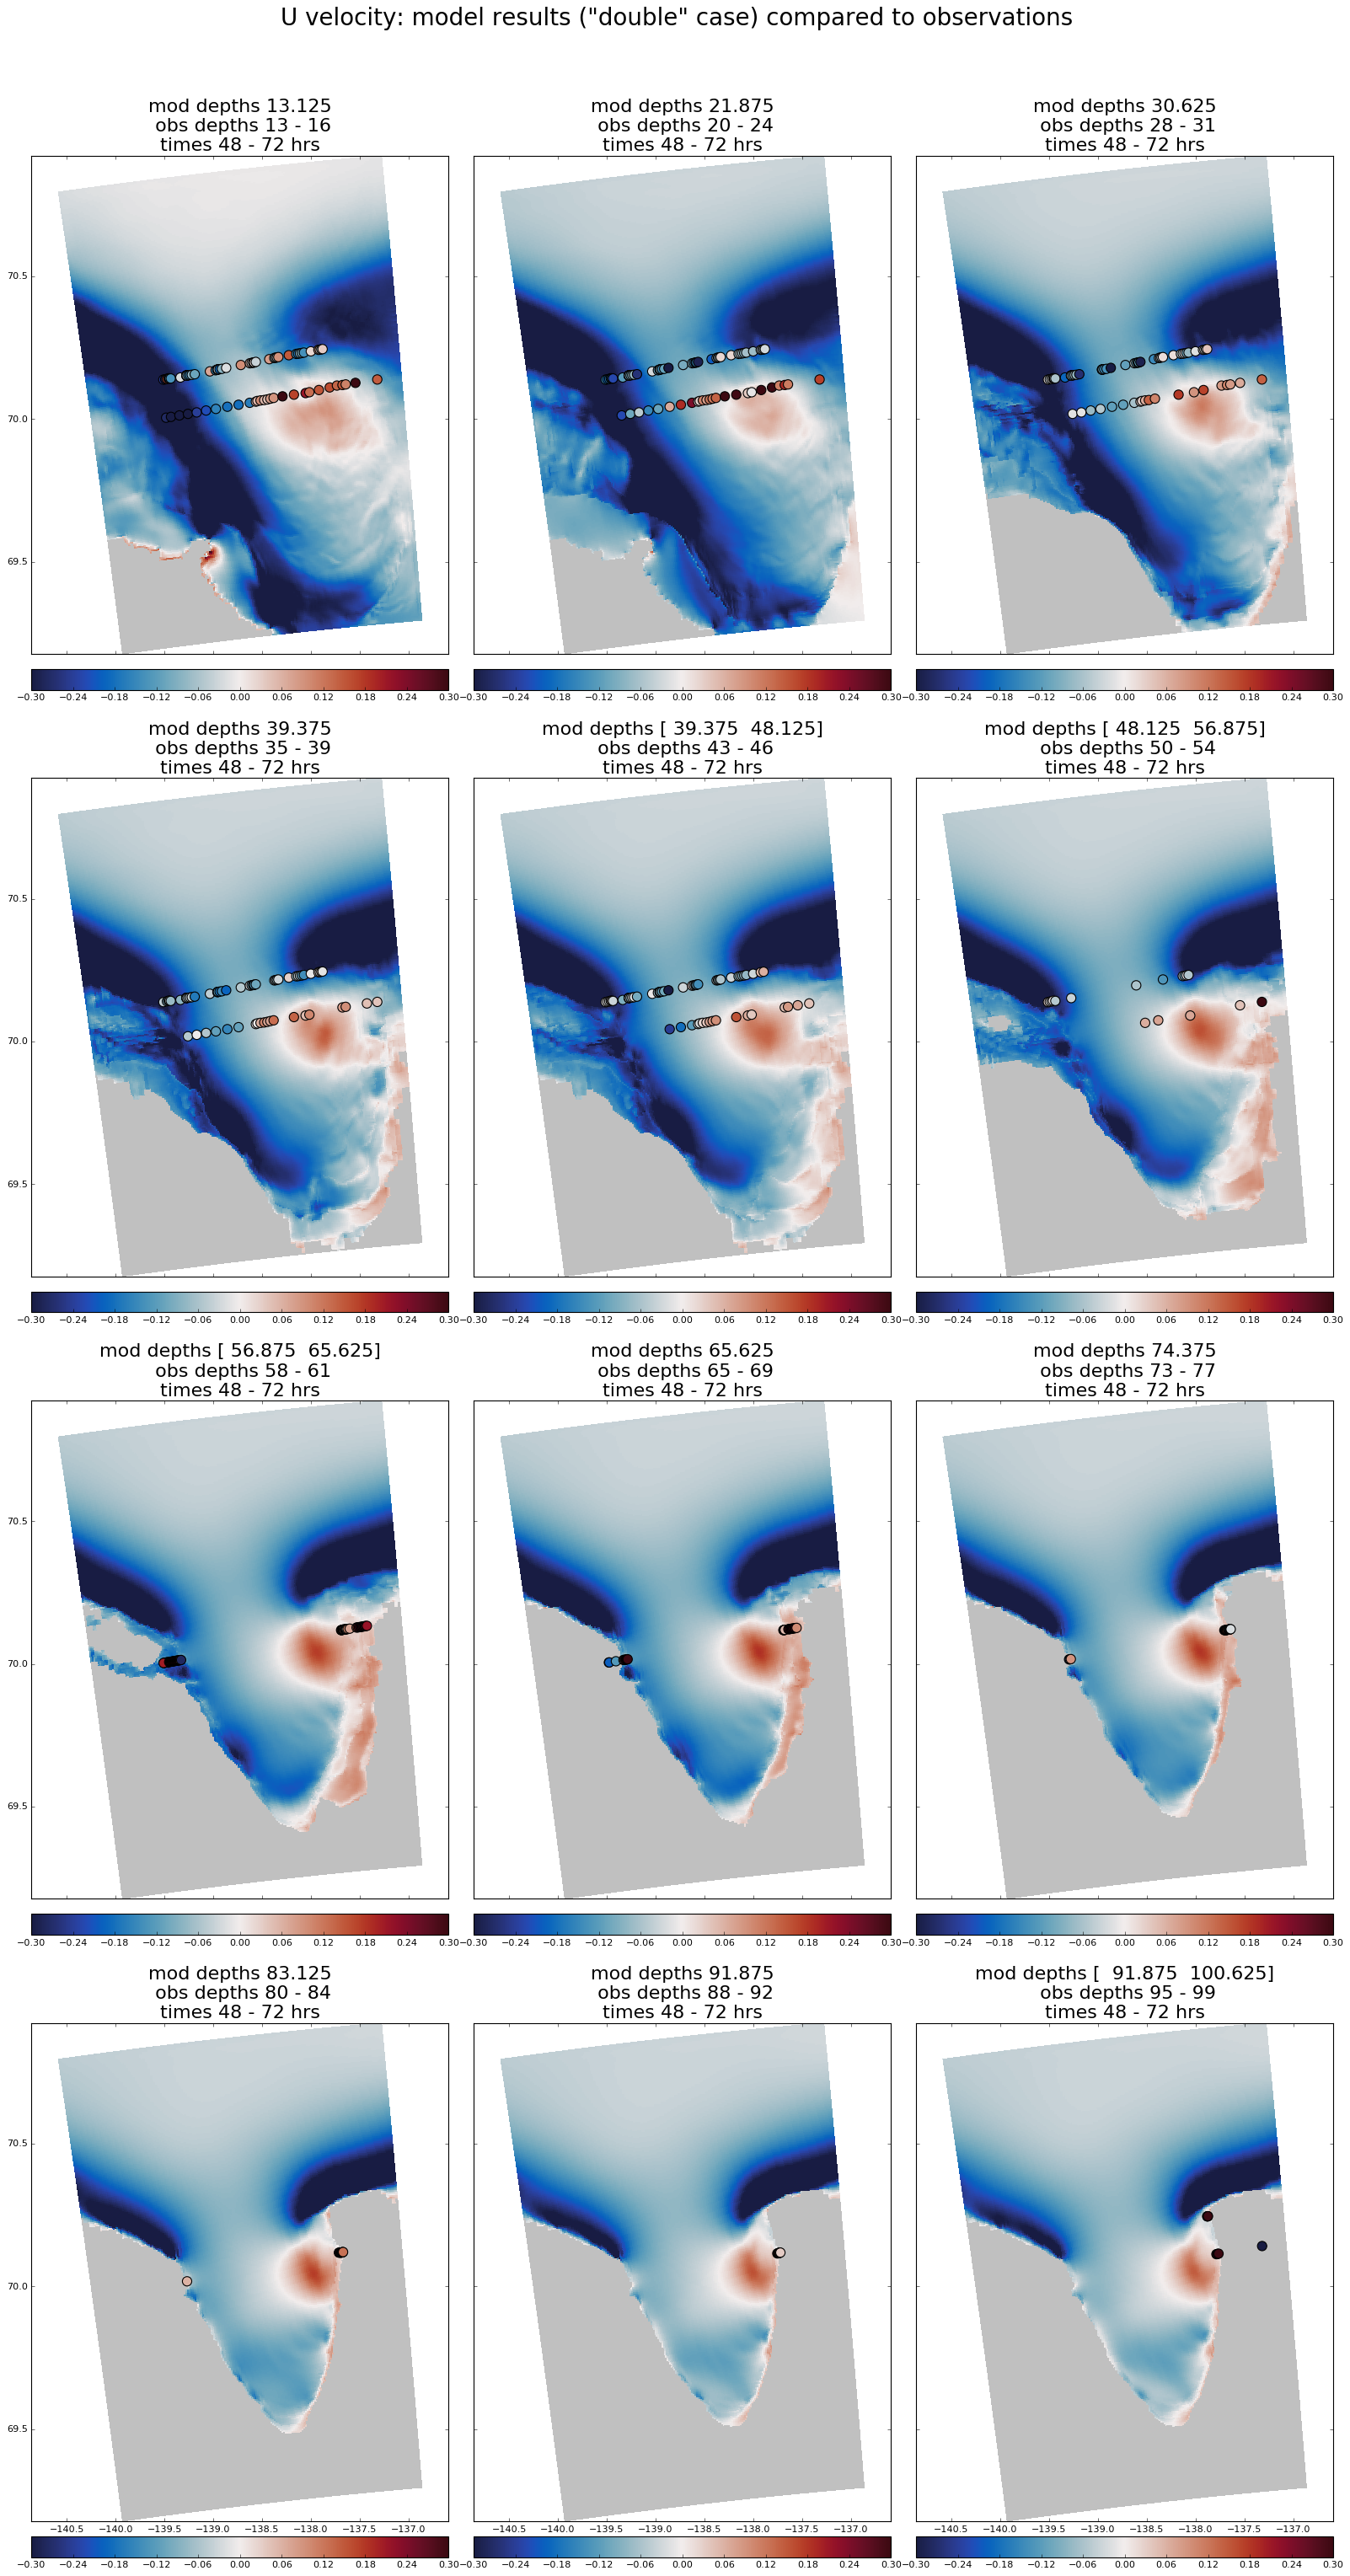

In [22]:
dirname = '/ocean/imachuca/Canyons/results_mackenzie/initial_collection/real_double/'
ttl = 'double'
velocity = 'U'

obs_vel_n = obs_u_n
obs_vel_s = obs_u_s

obz_z = obs_z_n
lon_n, lat_n = obs_lon_n, obs_lat_n
lon_s, lat_s = obs_lon_s, obs_lat_s

fig = plot_comparison(dirname, ttl, velocity, time_start, time_end, obs_vel_n, obs_vel_s, obz_z, lon_n, lat_n, lon_s, lat_s)